In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy import signal
def peak_cal(dynamicsPeak,dynamicsAmp,L,scale,dt):
    # dt: ms
    peaks=signal.find_peaks(dynamicsPeak[-L:],prominence=scale*max(dynamicsPeak[-L:]))
    freq, duty_cycle = None, None
    if np.size(peaks[0])>6:
        freq = 1.0/((peaks[0][-2]-peaks[0][-6])/4.0*dt)*1000.0 # return freq in Hz
        temp = dynamicsAmp[-L+peaks[0][-6]:-L+peaks[0][-2]]
        duty_cycle = np.size(temp[temp>0.1*max(temp)])/4.0*dt/1000.0 # return duty cycle in s
    return freq, duty_cycle

In [5]:
# wilson-cowan model with intrinsic properties
# Oct 15: add option of linear feedback current
# Oct 25: add options for new nonlinear function
class WC_Neuron:
    def __init__(self, s0 = 0.01, a0 = 0.0, dp0 = 0.0, Ja = 0.0, Jdp = 0.0, 
               taus = 7.5, taua = 1000.0, taudp = 1000.0, taur = 225.0, 
               x0 = 0.4, u0 = 0.1, uFlag = 1, UU = 0.2, rmax = 1.0, g = 1.0,
                frtype = 'relu'):
        
        self.initial_set = {'s0':s0, 'a0':a0, 'dp0':dp0, 'x0':x0, 'u0':u0}
        
        self.s = s0 # synaptic gating
        self.a = a0 # adaptation current
        self.dp = dp0 # depolarization current
        
        self.Ja = Ja # strength of adaptation current
        self.Jdp = Jdp # strength of depolarization current
        
        self.taus = taus 
        self.taua = taua
        self.taudp = taudp
        self.taur = taur # time scale of synaptic facilitation 
        
        self.x = x0 # synaptic depression 
        self.u = u0 # synaptic facilitation 
        
        self.UU = UU 
        
        self.uFlag = uFlag # have facilitation or not
        
        self.rmax = rmax
        self.g = g
        
        self.frtype = frtype
        
    def set_init(self): # set back to innitial values
        self.s = self.initial_set['s0'] # synaptic gating
        self.a = self.initial_set['a0'] # adaptation current
        self.dp = self.initial_set['dp0'] # depolarization current
        self.x = self.initial_set['x0'] # synaptic depression 
        self.u = self.initial_set['u0'] # synaptic facilitation 
        
        return self
        
    def fr(self, beta, sum_currents, I0): # firing rate
        return beta * self.lininter(sum_currents + I0 + self.dp - self.a)
    
    def lininter(self,x):
        if self.frtype == 'relu':
            return np.heaviside(x,0)*x
        if self.frtype == 'tanh':
            y = np.tanh(self.g*(x))*self.rmax + self.rmax
            return np.heaviside(y,0)*y
        
    def update(self, NeuronList, ConnList, beta, dt, I0): # update all variables at one time step
        
        sum_currents = 0
        for i, neuron in enumerate(NeuronList):
            sum_currents += neuron.s * ConnList[i]
        
        self.m = self.fr(beta, sum_currents, I0)
        
        dp_next = self.dp + dt * (-self.dp + self.Jdp * self.m)/self.taudp
        s_next = self.s + dt * (-self.s/self.taus + self.x*self.m*self.u)
        a_next = self.a + dt * (-self.a + self.Ja*self.m)/self.taua
        
        if self.uFlag == 1:  
            u_next = self.u + dt*((self.UU - self.u)/self.taur + self.UU*(1.0-self.u)*self.x*self.m)
            self.u = u_next

        self.s = s_next
        self.dp = dp_next
        self.a = a_next
        
        return self
        

In [6]:
# network of WCneurons
class WC_NN:
    def __init__(self, ListWCNeuron, ConnMat, beta = 0.011, dt = 0.2, 
                 toFeedback = None, fromFeedback = None, updatingrate = 0.0):
        self.ListWCNeuron = ListWCNeuron # list of WC_Neuron
        self.ConnMat = ConnMat # rows: to, cols: from
        self.beta = beta
        self.dt = dt
        self.Npops = len(ListWCNeuron)
        self.toFeedback = toFeedback
        if self.toFeedback is not None: 
            """
            only applies when you have 2 modules, specify the *index* of 2 population to compute difference in 
            toFeedback list
            specify populations receiving feedback in fromFeedback by *connectivity*
            """
            self.hist_diff = 0.0
            self.updatingrate = updatingrate
            self.fromFeedback = fromFeedback

        
    def update(self, I0): # update all populations in the network in one time step
        NewNeurons = []
        if self.toFeedback is not None:
            I0 = I0 + self.fbCurrent * self.fromFeedback
        for i, pops in enumerate(self.ListWCNeuron):
            NewNeurons.append(pops.update(NeuronList = self.ListWCNeuron, 
                                          ConnList = self.ConnMat[i], 
                                          beta = self.beta, 
                                          dt = self.dt,
                                         I0 = I0[i]))
        self.ListWCNeuron = NewNeurons
        if self.toFeedback is not None:
            self.hist_diff = self.ListWCNeuron[self.toFeedback[0]].m - self.ListWCNeuron[self.toFeedback[1]].m
            self.fbCurrent += self.dt * self.updatingrate * self.hist_diff
    
    def init_dynamics(self,T): # initialize array to store variables
        # arrays to store dynamics
        self.Npts = int(T/self.dt)
        self.marr = np.zeros((self.Npops, self.Npts))
        self.sarr = np.zeros((self.Npops, self.Npts))
        self.aarr = np.zeros((self.Npops, self.Npts))
        self.uarr = np.zeros((self.Npops, self.Npts))
        self.dparr = np.zeros((self.Npops, self.Npts))
        if self.toFeedback is not None:
            self.fbCurrent_arr = np.zeros((1, self.Npts))
            self.fbCurrent = 0.0

        initNeurons = []
        for i in range(len(self.ListWCNeuron)):
            initNeurons.append(self.ListWCNeuron[i].set_init())
        self.ListWCNeuron = initNeurons

    def record(self,curr): # record variable at one time point
        for kk, Neurons in enumerate(self.ListWCNeuron):
            self.marr[kk, curr] = self.ListWCNeuron[kk].m
            self.sarr[kk, curr] = self.ListWCNeuron[kk].s
            self.aarr[kk, curr] = self.ListWCNeuron[kk].a
            self.uarr[kk, curr] = self.ListWCNeuron[kk].u
            self.dparr[kk, curr] = self.ListWCNeuron[kk].dp
        if self.toFeedback is not None:
            self.fbCurrent_arr[0,curr] = self.fbCurrent
             
    def concat_NN(self, WC_NN2, InterMat_to, InterMat_from): # concatenate one WC_NN with another
        NewListWCNeuron = self.ListWCNeuron + WC_NN2.ListWCNeuron
        NewConnMat = np.zeros((len(NewListWCNeuron),len(NewListWCNeuron)))
        NewConnMat[:self.Npops,:self.Npops] = self.ConnMat
        NewConnMat[self.Npops:,self.Npops:] = WC_NN2.ConnMat
        NewConnMat[:self.Npops,self.Npops:] = InterMat_to
        NewConnMat[self.Npops:,:self.Npops] = InterMat_from
        return NewListWCNeuron,NewConnMat

In [7]:
def setMyPlot(figsize):
    plt.figure(figsize=figsize)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    ax = plt.gca()
    width=2
    ax.spines['top'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['left'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13) 

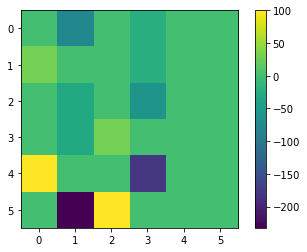

In [8]:
# add MNs to the network, simulate and compute frequency
# Assuming that I neurons are V1/V2b, with V1 inhibit MF more, and V2b inhibit MX more
# Sept 26 update: add facilitation
EF = WC_Neuron(Ja = 140.0, Jdp = 110.0, 
               taus = 9.5/2, taua = 400.0/2, taudp = 6.5/2, taur = 225.0, 
               x0 = 0.8, u0 = 0.4*2, uFlag = 1)
IF = WC_Neuron(Ja = 180.0, Jdp = 0.0, 
               taus = 6.5, taua = 75.0, taudp = 1000.0, taur = 225.0, 
               x0 = 0.4, u0 = 0.2, uFlag = 1)
EX = WC_Neuron(Ja = 140.0, Jdp = 110.0, 
               taus = 9.5/2, taua = 400.0/2, taudp = 6.5/2, taur = 225.0, 
               x0 = 0.8, u0 = 0.4*2, uFlag = 1)
IX = WC_Neuron(Ja = 180.0, Jdp = 0.0, 
               taus = 6.5, taua = 75.0, taudp = 1000.0, taur = 225.0, 
               x0 = 0.4, u0 = 0.2, uFlag = 1)
MF = WC_Neuron(Ja = 0.0, Jdp = 0.0, 
               taus = 6.5, taua = 75.0, taudp = 1000.0, taur = 225.0, 
               x0 = 0.4, u0 = 0.4, uFlag = 1)
MX = WC_Neuron(Ja = 0.0, Jdp = 0.0, 
               taus = 6.5, taua = 75.0, taudp = 1000.0, taur = 225.0, 
               x0 = 0.4, u0 = 0.4, uFlag = 1)

Jee2 = 0
Jie2 = 30
Jei2 = 50
Jii2 = 0
Jee = 0.0
Jii = 20.0
Jei = 20.0

Jme=100 
Jmi=150

Escale = 1.0
V1scale = 1.0
V2bscale = 1
Iscale = 1
V2b_inp_scale = 1
V1_inp_scale = 1

V1F = 0.3 # 0.3
V1X = 0.9 # 0.9
V2bF = 1.25 # 1.25
V2bX = 0.3 # 0.3   

I0I = 0.3

IscaleX = (V1scale* V1X+ V2bscale*V2bX)
IscaleF = (V1scale* V1F+ V2bscale*V2bF)
I0I_F = (V1_inp_scale * V1F + V2b_inp_scale*V2bF)*I0I
I0I_X = (V1_inp_scale * V1X + V2b_inp_scale*V2bX)*I0I   

#
#IscaleX = 1.0
#IscaleF = 1.0

ListWCNeuron = [EF, IF, EX, IX, MF, MX]

ConnMat = np.array([[Escale*Jee2, IscaleF*-Jei2, Escale*Jee, IscaleX*-Jei, 0.0, 0.0],
                   [Escale*Jie2, IscaleF*-Jii2, 0.0, IscaleX*-Jii, 0.0, 0.0],
                   [Escale*Jee, IscaleF*-Jei, Escale*Jee2, IscaleX*-Jei2, 0.0, 0.0],
                   [0.0, IscaleF*-Jii, Escale*Jie2, IscaleX*-Jii2, 0.0, 0.0],
                   [Escale * Jme, 0.0, 0.0, -IscaleX*Jmi, 0.0, 0.0],
                   [0.0, -IscaleF*Jmi,Escale * Jme, 0.0, 0.0, 0.0]])
plt.imshow(ConnMat)
plt.colorbar()

In [9]:
FinalNN = WC_NN(ListWCNeuron,ConnMat, beta = 0.011, dt = 0.2)

In [10]:
T = 6000
FinalNN.init_dynamics(T)
inp_arr = [0.3, I0I_F, 0.3, I0I_X, 0.1, 0.1]
for i in range(FinalNN.Npts):
    FinalNN.update(inp_arr)
    FinalNN.record(i)

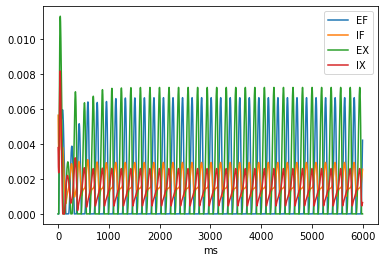

In [11]:
tt = np.linspace(0, T, FinalNN.Npts)
plt.plot(tt,FinalNN.marr[0], label = 'EF')
plt.plot(tt,FinalNN.marr[1], label = 'IF')
plt.plot(tt,FinalNN.marr[2], label = 'EX')
plt.plot(tt,FinalNN.marr[3], label = 'IX')
plt.xlabel('ms')
plt.legend()

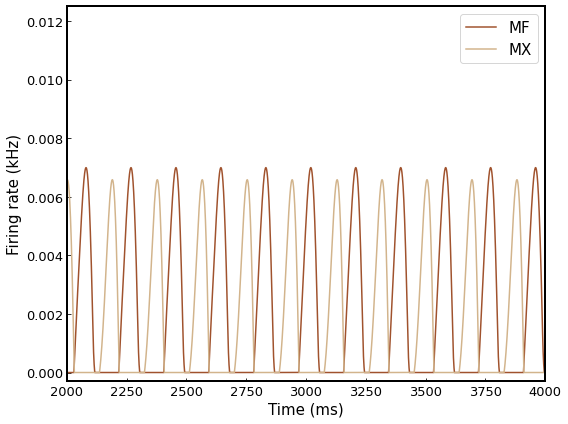

In [12]:
setMyPlot((8,6))
tt = np.linspace(0, T, FinalNN.Npts)
plt.plot(tt,FinalNN.marr[4], label = 'MF', color = 'sienna')
plt.plot(tt,FinalNN.marr[5], label = 'MX',color = 'tan')
plt.xlabel('Time (ms)',fontsize =15)
plt.ylabel('Firing rate (kHz)', fontsize = 15)
plt.xlim([2000,4000])
plt.ylim([-0.0003, 0.0125])
plt.legend(fontsize = 15)
plt.tight_layout()
#plt.savefig('../wk1003/TwoModules_asym.eps',format = 'eps')

In [52]:
"""
"Nonlinear Muscle" model
cr. Akira Nagamori
"""
# Define muscle model functions
import time 

def FL_function(L):
    beta = 1.55
    omega = 0.75
    rho = 2.12
    
    FL = np.exp(-np.power(abs((np.power(L,beta) - 1)/(omega)),rho));
    return FL

def FV_con_function(L,V):
    Vmax = -9.15*2;
    cv0 = -5.7;
    cv1 = 9.18;
    
    FVcon = (Vmax - V)/(Vmax + (cv0 + cv1*L)*V);
    return FVcon

def FV_ecc_function(L,V):
    av0 = -1.4;
    av1 = 0.0;
    av2 = 0.0;
    bv = 0.72;
    FVecc = (bv - (av0 + av1*L + av2*np.power(L,2))*V)/(bv+V);
    
    return FVecc

def Fpe_function(L,V):
    c1_pe1 = 23.0*6
    k1_pe1 = 0.046
    Lr1_pe1 = 1.17
    eta = 0.0001;
    
    Fpe1 = c1_pe1 * k1_pe1 * np.log(np.exp((L - Lr1_pe1)/(k1_pe1))+1) + eta*V;
    
    return Fpe1

def forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2):
    # Minimum joint angle
    theta_min = 40*np.pi/180.0
    # Maximum joint angle
    theta_max = 110*np.pi/180.0
    
    # Muscle time constant (sec)
    tau_1 = 0.005;
    tau_2 = 0.005;
    
    Lce_1 = x[6]/Lce0_1
    Lce_2 = x[7]/Lce0_2
    Vce_1 = -r_m1*x[5]/Lce0_1
    Vce_2 = -r_m2*x[5]/Lce0_2
    
    FL_1 = FL_function(Lce_1)
    FL_2 = FL_function(Lce_1)
    
    if Vce_1 <= 0:
        FV_1 = FV_con_function(Lce_1,Vce_1)
    else:
        FV_1 = FV_ecc_function(Lce_1,Vce_1)
    if Vce_2 <= 0:
        FV_2 = FV_con_function(Lce_2,Vce_2)
    else:
        FV_2 = FV_ecc_function(Lce_2,Vce_2)
        
    Fpe_1 = Fpe_function(Lce_1/Lmax_1,Vce_1)
    Fpe_2 = Fpe_function(Lce_2/Lmax_2,Vce_2)
    
    Fm_1 = (FL_1*FV_1*x[0]+Fpe_1)*F0_1
    Fm_2 = (FL_2*FV_2*x[2]+Fpe_2)*F0_2
        
    T_stop_1 = 0.01*np.exp(-(x[4]-theta_min)/0.01)
    T_stop_2 = -0.01*np.exp((x[4]-theta_max)/0.01)
    
    dx[0] = x[1]
    dx[1] = -x[0]/(tau_1*tau_2) - x[1]*(tau_1+tau_2)/(tau_1*tau_2) + u[0]/(tau_1*tau_2)
    dx[2] = x[3]
    dx[3] = -x[2]/(tau_1*tau_2) - x[3]*(tau_1+tau_2)/(tau_1*tau_2) + u[1]/(tau_1*tau_2)
    dx[4] = x[5]
    dx[5] = (Fm_1*r_m1 + Fm_2*r_m2 + T_stop_1 + T_stop_2)/I - B*x[5] - K*x[4]
    dx[6] = -r_m1*x[5]
    dx[7] = -r_m2*x[5]
    return dx

3.557278871536255


(32.211218737354095, 118.156738010077)

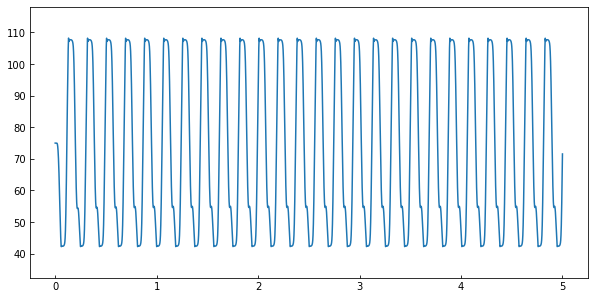

In [53]:

mMF = FinalNN.marr[4]
mMX = FinalNN.marr[5]
dt = 0.2
# Define simulation parameters
Fs = 1000.0/dt # dt = 0.2
h = 1/Fs

#Define inputs
# u_1: flexor, u_2: extensor
# Set the amplitude of step inputs
T_sim = int(mMF.shape[0]*dt-1000)
time_sim = np.arange(0,T_sim/1000,step = 1/Fs)# time vector 
duration = T_sim/1000 # duration of simulation in samples 

scale= 0.03
u_1 = np.array((mMF[-int(T_sim/dt+1):-1])/scale)
u_2 = (mMX[-int(T_sim/dt+1):-1])/scale

# Segment length
L = 0.03 
# Distance between the rotational axis and the center of the segment 
d = 0
# Segment mass
M = 0.0004
# Segment inertia
I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
# Stiffness
K = 0.0
# Viscosity 
B = 0.0001

# Minimum joint angle
theta_min = 40*np.pi/180.0
# Maximum joint angle
theta_max = 110*np.pi/180.0
# Positive angle change => dorsiflexion 

# Maximum muscle force (N)
F0_1 = (7.64+1.52+0.35)*0.01*22.4
F0_2 = (7.64+1.52+0.35)*0.01*22.4 #(7.43+14.57+1.42+3.67+7.3+2.15)*0.01*22.4
# Optimal muscle fiber length
Lce0_1 = 0.473*0.01; # Average fiber length of all dorsiflexors 
Lce0_2 = 0.473*0.01 #0.389*0.01; # Average fiber length of all plantarflexors 
# Maximum muscle fiber legnth at the anatomical limit of range of motion (i.e. minimum and maximum joint angles)
Lmax_1 = 1.1;
Lmax_2 = 1.1;

# Muscle time constant (ms)
tau_1 = 0.005;
tau_2 = 0.005;

# Moment arm (m)
r_m1 = 0.001 #0.0006
r_m2 = -0.001 #-0.0015
dLm = -r_m1*(theta_max-theta_min)
Lce_min_1 = (dLm + Lmax_1*Lce0_1)/Lce0_1
dLm = -r_m2*(theta_min-theta_max)
Lce_min_2 = (dLm + Lmax_2*Lce0_2)/Lce0_2
theta_vec = np.linspace(theta_min,theta_max,1000)
Lce_1 = np.zeros(len(theta_vec))
Lce_1[0] = Lmax_1
Fpe_1 = np.zeros(len(theta_vec))
Fpe_1[0] = Fpe_function(1,0)*F0_1
Lce_2 = np.zeros(len(theta_vec))
Lce_2[0] = Lce_min_2
Fpe_2 = np.zeros(len(theta_vec))
Fpe_2[0] = Fpe_function(Lce_min_2/Lmax_2,0)*F0_2
for i in range(1,len(theta_vec)):
    dLm_1 = -r_m1*(theta_vec[i]-theta_vec[i-1])
    Lce_1[i] = (dLm_1 + Lce_1[i-1]*Lce0_1)/Lce0_1
    Fpe_1[i] = Fpe_function(Lce_1[i]/Lmax_1,0)*F0_1

    dLm_2 = -r_m2*(theta_vec[i]-theta_vec[i-1])
    Lce_2[i] = (dLm_2 + Lce_2[i-1]*Lce0_2)/Lce0_2
    Fpe_2[i] = Fpe_function(Lce_2[i]/Lmax_2,0)*F0_2

eq_theta = theta_vec[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
eq_theta*180/np.pi

theta = eq_theta
dtheta = 0
Lm_1 = Lce_1[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_1 = Lm_1*Lce0_1
Lm_2 = Lce_2[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_2 = Lm_2*Lce0_2
x = np.array([0.0, 0.0, 0.0, 0.0, theta, dtheta, Lm_1, Lm_2])
dx = np.zeros(8)
x_mat = np.zeros((int(duration*Fs),len(x)))

#Start forward simulations
t0 = time.time()
for t in range(int(duration*Fs)):
    u = np.concatenate(([u_1[t]],[u_2[t]]))
    f1 = forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x1 = x + f1*h/2
    f2 = forward_dynamis(x1,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x2 = x + f2*h/2
    f3 = forward_dynamis(x2,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x3 = x + f3*h
    f4 = forward_dynamis(x3,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x = x + (f1+2*f2+2*f3+f4)*h/6
    x_mat[t,:] = x

tf = time.time()
total = tf-t0
print(total)

min_angle = np.min(np.rad2deg(x_mat[:,4]))
max_angle = np.max(np.rad2deg(x_mat[:,4]))
plt.plot(time_sim,np.rad2deg(x_mat[:,4]))
plt.ylim([min_angle-10, max_angle+10])


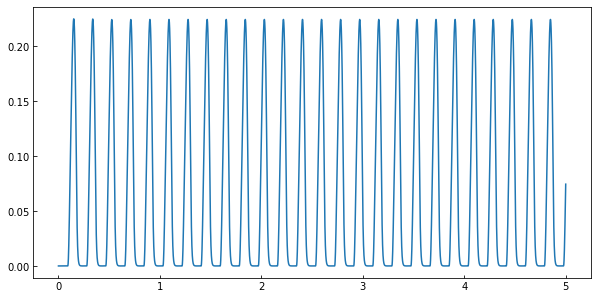

In [54]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(time_sim,x_mat[:,0])

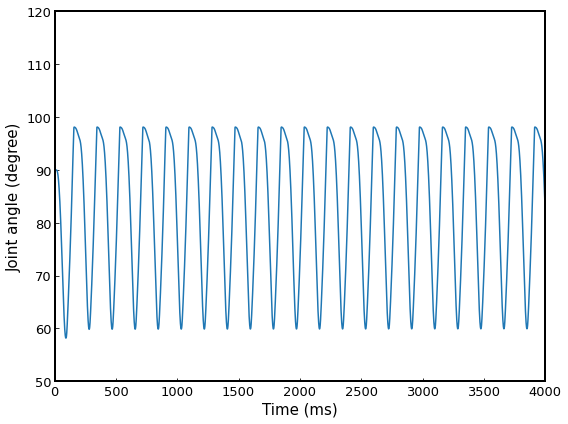

In [13]:
setMyPlot((8,6))
plt.plot(time_sim.data.cpu().numpy()*1000,np.rad2deg(x_mat[:,0].data.cpu().numpy()))
plt.xlabel('Time (ms)',fontsize =15)
plt.ylabel('Joint angle (degree)',fontsize=15)
plt.xlim([0,4000])
plt.ylim([50,120])
plt.tight_layout()